# **이미지 모델링 실습**


## **1. 환경준비**

In [1]:
# 라이브러리 로딩
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.preprocessing import MinMaxScaler
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam

# 디바이스 준비
device = 'cuda' if torch.cuda.is_available() else 'cpu'

* 딥러닝을 위한 데이터로더 만들기

In [2]:
def make_DataSet(x_train, x_val, y_train, y_val, batch_size = 32) :
    # 텐서로 변환
    x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    x_val_tensor = torch.tensor(x_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.long)

    # TensorDataset 생성: 텐서 데이터 세트로 합치기
    train_dataset = TensorDataset(x_train_tensor, y_train_tensor)

    # DataLoader 생성
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle = True)
    return train_loader, x_val_tensor, y_val_tensor

* 학습을 위한 함수

In [3]:
def train(dataloader, model, loss_fn, optimizer, device):
    size = len(dataloader.dataset) # 전체 데이터 세트의 크기
    num_batches = len(dataloader) # 배치 크기
    tr_loss = 0

    model.train() # 학습 모드로 설정
    for x, y in dataloader: # 배치 단위로 로딩
        x, y = x.to(device), y.to(device) # 디바이스 지정

        # Feed Forward(오차 순전파)
        pred = model(x)
        loss = loss_fn(pred, y)
        tr_loss += loss

        # Backpropagation(오차 역전파)
        loss.backward() # 역전파를 통해 각 파라미터에 대한 오차의 기울기 계산
        optimizer.step() # 옵티마이저가 모델의 파라미터를 업데이트
        optimizer.zero_grad() # 옵티마이저의 기울기값 초기화.

    tr_loss /= num_batches # 모든 배치의 오차 평균
    return tr_loss.item()

* 검증을 위한 함수

In [4]:
def evaluate(x_val_tensor, y_val_tensor, model, loss_fn, device):
    model.eval() # 모델을 평가 모드로 설정

    with torch.no_grad(): # 평가 과정에서 기울기를 계산하지 않도록 설정
        x, y = x_val_tensor.to(device), y_val_tensor.to(device)
        pred = model(x)
        eval_loss = loss_fn(pred, y).item() # 예측값 pred와 목푯값 y 사이의 오차 계산

    return eval_loss, pred

* 학습곡선

In [5]:
def dl_learning_curve(tr_loss_list, val_loss_list):
    epochs = list(range(1, len(tr_loss_list)+1)) # 에포크 수 계산
    plt.plot(epochs, tr_loss_list, label='train_err', marker = '.') # 학습 오차 그래프
    plt.plot(epochs, val_loss_list, label='val_err', marker = '.') # 검증 오차 그래프
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

## **2. 실습: 컬러 이미지 분류 모델링**

### (1) 데이터 전처리

* 데이터 로딩

In [6]:
from torchvision import datasets
from torchvision.transforms import ToTensor
train_dataset = datasets.CIFAR10(root="data", train=True, download=True, transform=ToTensor())
test_dataset = datasets.CIFAR10(root="data", train=False, download=True, transform=ToTensor())

100%|██████████| 170M/170M [00:11<00:00, 14.4MB/s]


In [7]:
train_dataset.data.shape

(50000, 32, 32, 3)

In [8]:
classes = train_dataset.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

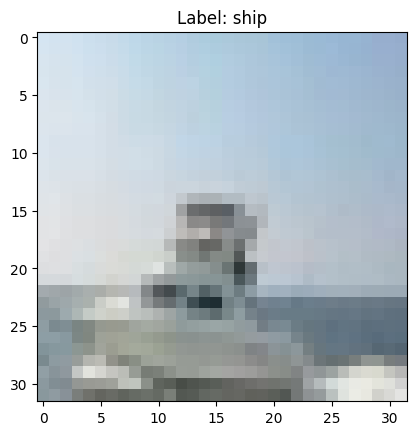

In [9]:
n = 100
image, label = train_dataset.data[n], train_dataset.targets[n]
plt.imshow(image)
plt.title(f"Label: {train_dataset.classes[label]}")
plt.show()

* 데이터 전처리

In [10]:
# 학습 데이터의 데이터 로더
train_loader = DataLoader(train_dataset, batch_size = 64)

# 검증, 테스트 데이터를 위한 텐서 데이터 세트 준비
## val, test 분할
x_val, x_test = test_dataset.data[:5000], test_dataset.data[5000:]
y_val, y_test = test_dataset.targets[:5000], test_dataset.targets[5000:]

## 스케일링
x_val = x_val / 255
x_test = x_test/ 255

## 차원 맞추기 - 기존 차원: [데이터 건수, 세로 픽셀, 가로 픽셀, 채널(컬러)]
print('기존: ', x_val.shape, x_test.shape)

## 차원 위치 조정: [데이터 건수, 채널(컬러), 세로 픽셀, 가로 픽셀]
x_val = x_val.transpose((0, 3, 1, 2))
x_test = x_test.transpose((0, 3, 1, 2))

print('조정: ', x_val.shape, x_test.shape)
## 텐서로 변환
x_val = torch.tensor(x_val, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

기존:  (5000, 32, 32, 3) (5000, 32, 32, 3)
조정:  (5000, 3, 32, 32) (5000, 3, 32, 32)


### (2) 모델링

* 모델 설계

In [11]:
class CNN_model3(nn.Module):
    def __init__(self):
        super(CNN_model3, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=32,
        kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2))
        self.conv2 = nn.Sequential(nn.Conv2d(in_channels=32, out_channels=64,
        kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2))
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [12]:
model = CNN_model3().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

* 학습 및 검증 평가

In [13]:
# 학습
epochs = 10
tr_loss_list, val_loss_list = [], []
for t in range(epochs):
    tr_loss = train(train_loader, model, loss_fn, optimizer, device)
    val_loss,_ = evaluate(x_val, y_val, model, loss_fn, device)
    tr_loss_list.append(tr_loss)
    val_loss_list.append(val_loss)
    print(f"Epoch {t+1}, train loss : {tr_loss:.4f}, val loss : {val_loss:.4f}")

# 예측
_, pred = evaluate(x_test, y_test, model, loss_fn, device)
pred = nn.functional.softmax(pred, dim=1)
pred = np.argmax(pred.cpu().numpy(), axis = 1)

# 평가
print(classification_report(y_test.numpy(), pred, digits = 4))

Epoch 1, train loss : 1.4809, val loss : 1.1965
Epoch 2, train loss : 1.1065, val loss : 0.9881
Epoch 3, train loss : 0.9527, val loss : 0.9154
Epoch 4, train loss : 0.8517, val loss : 0.8977
Epoch 5, train loss : 0.7734, val loss : 0.8913
Epoch 6, train loss : 0.7020, val loss : 0.8964
Epoch 7, train loss : 0.6389, val loss : 0.9060
Epoch 8, train loss : 0.5839, val loss : 0.9217
Epoch 9, train loss : 0.5379, val loss : 0.9568
Epoch 10, train loss : 0.4926, val loss : 1.0133
              precision    recall  f1-score   support

           0     0.7387    0.7676    0.7529       512
           1     0.8614    0.7030    0.7742       495
           2     0.5799    0.6025    0.5910       488
           3     0.4974    0.5626    0.5280       503
           4     0.7139    0.6126    0.6594       493
           5     0.5926    0.6250    0.6084       512
           6     0.7130    0.7859    0.7477       509
           7     0.7967    0.7604    0.7781       505
           8     0.8690    0.735